<center><h1>McGill University ECSE 415 Introduction to Computer Vision</h1>
<h2>Assignment V Segmentation</h2>
<h4>@author: Alex Wei &nbsp; &nbsp; @version: 1.0.3</h4></center>

## *¡README!*
1. This assignment was written in IntelliJ IDEA 2023.2, Python 3.11. If you are running in a different environment like Google Colab, please first ensure you make appropriate adaptation to the code.
2. For convolution in Q1.1, `scipy.signal.convolve2d()` and `cv2.filter2D()` have different output styles. This is probably due to how the two handle even numbers of kernel dimensions. They were both displayed out of rigor. Also for either, zero-padding actually doesn't matter much since they inherently deal with it.

&nbsp;
## Version History
**v0.1 12/11/2023 Initial submission**

**v0.2 13/11/2023**
1. Bug fix: (Part 2) objects in the same category now have the same color filter.
2. Minor code optimizations.

**v1.0.4 22/11/2023 Final submission**
1. Bug fix: (Part 1) outputs corrected.
2. Enhancement: (Part 2, rcnn()) i) enabled a uniform font size and box thickness for varying input resolutions & aspect ratios; ii) got rid of overlapping boxes with NMS (transplanted from A4).
3. Improved readability.
4. Minor code optimizations.

&nbsp;
## I - K-Means and Mean-Shift Clustering for Segmentation

In [23]:
import cv2
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, hsv2rgb
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth as esb
from torch import no_grad
from torchvision.ops import nms
import torchvision.transforms as t
from torchvision.models.detection import maskrcnn_resnet50_fpn as m, MaskRCNN_ResNet50_FPN_Weights as M

PATH = './Data/'    # change to your own path to apply globally

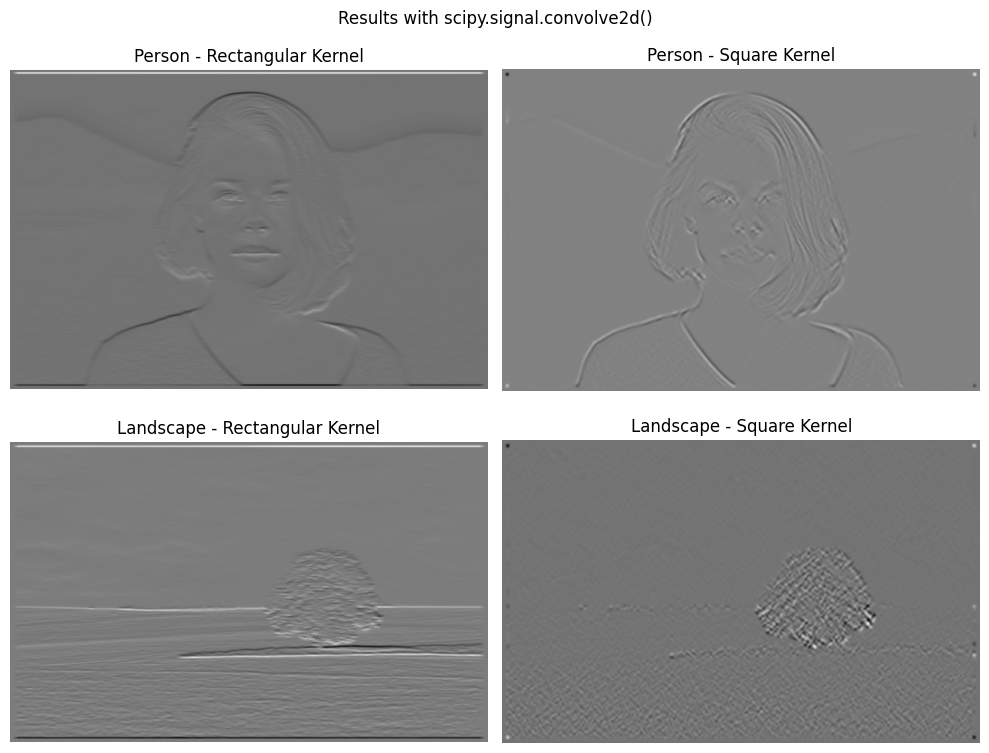

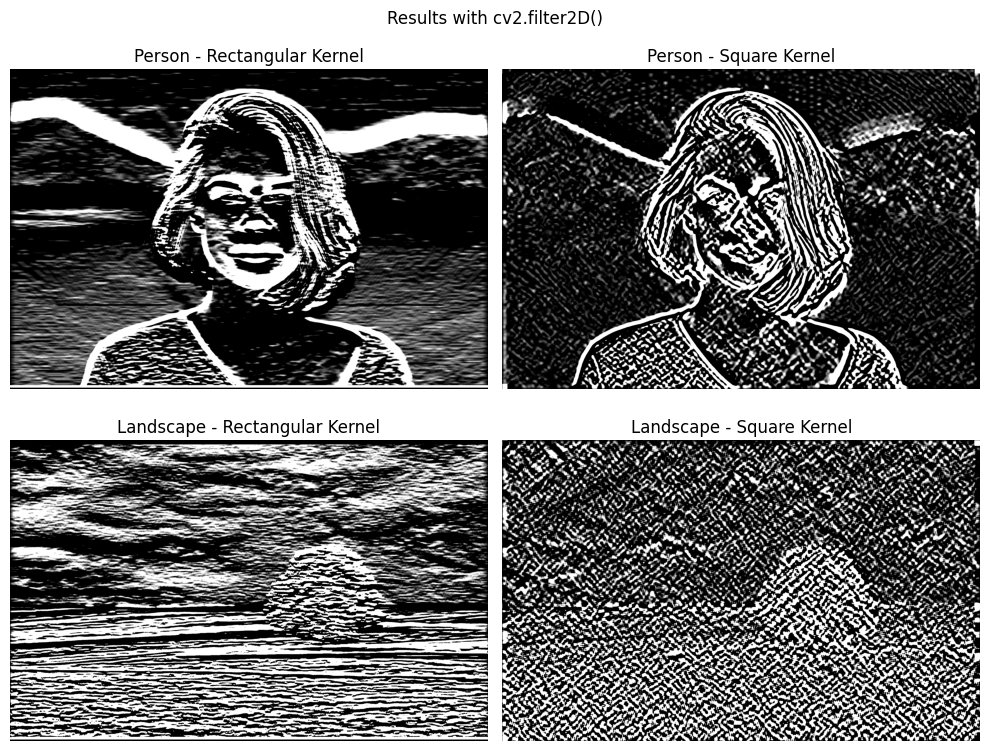

In [24]:
pics = [PATH + 'Person.png', PATH + 'landscape.png']
# REF[1][2]
# width determined by ((S−1)W−S+F)/2, S=1. no need for integral image since used only once and already fast enough
p = np.pad(cv2.imread(pics[0], cv2.IMREAD_GRAYSCALE), pad_width = 12)
l = np.pad(cv2.imread(pics[1], cv2.IMREAD_GRAYSCALE), pad_width = 12)
k1 = np.ones((12, 24))
k1[6:, :] = -1
k2 = np.ones((24, 24))
k2[12:, 12:], k2[:12, :12] = -1, -1

out1, out2 = [], []
imgs = [('Person', p), ('Landscape', l)]
kers = [('Rectangular Kernel', k1), ('Square Kernel', k2)]
for _, image in imgs:
    for _, ker in kers:
        out1.append(convolve2d(image, ker)) # same as my own implementation
        out2.append(cv2.filter2D(image, -1, ker))
plt.figure(figsize = (10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f'{imgs[i // 2][0]} - {kers[i % 2][0]}')
    plt.imshow(out1[i], cmap = 'gray')
    plt.axis('off')
plt.suptitle('Results with scipy.signal.convolve2d()')
plt.tight_layout()
plt.show()

plt.figure(figsize = (10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f'{imgs[i // 2][0]} - {kers[i % 2][0]}')
    plt.imshow(out2[i], cmap = 'gray')
    plt.axis('off')
plt.suptitle('Results with cv2.filter2D()')
plt.tight_layout()
plt.show()

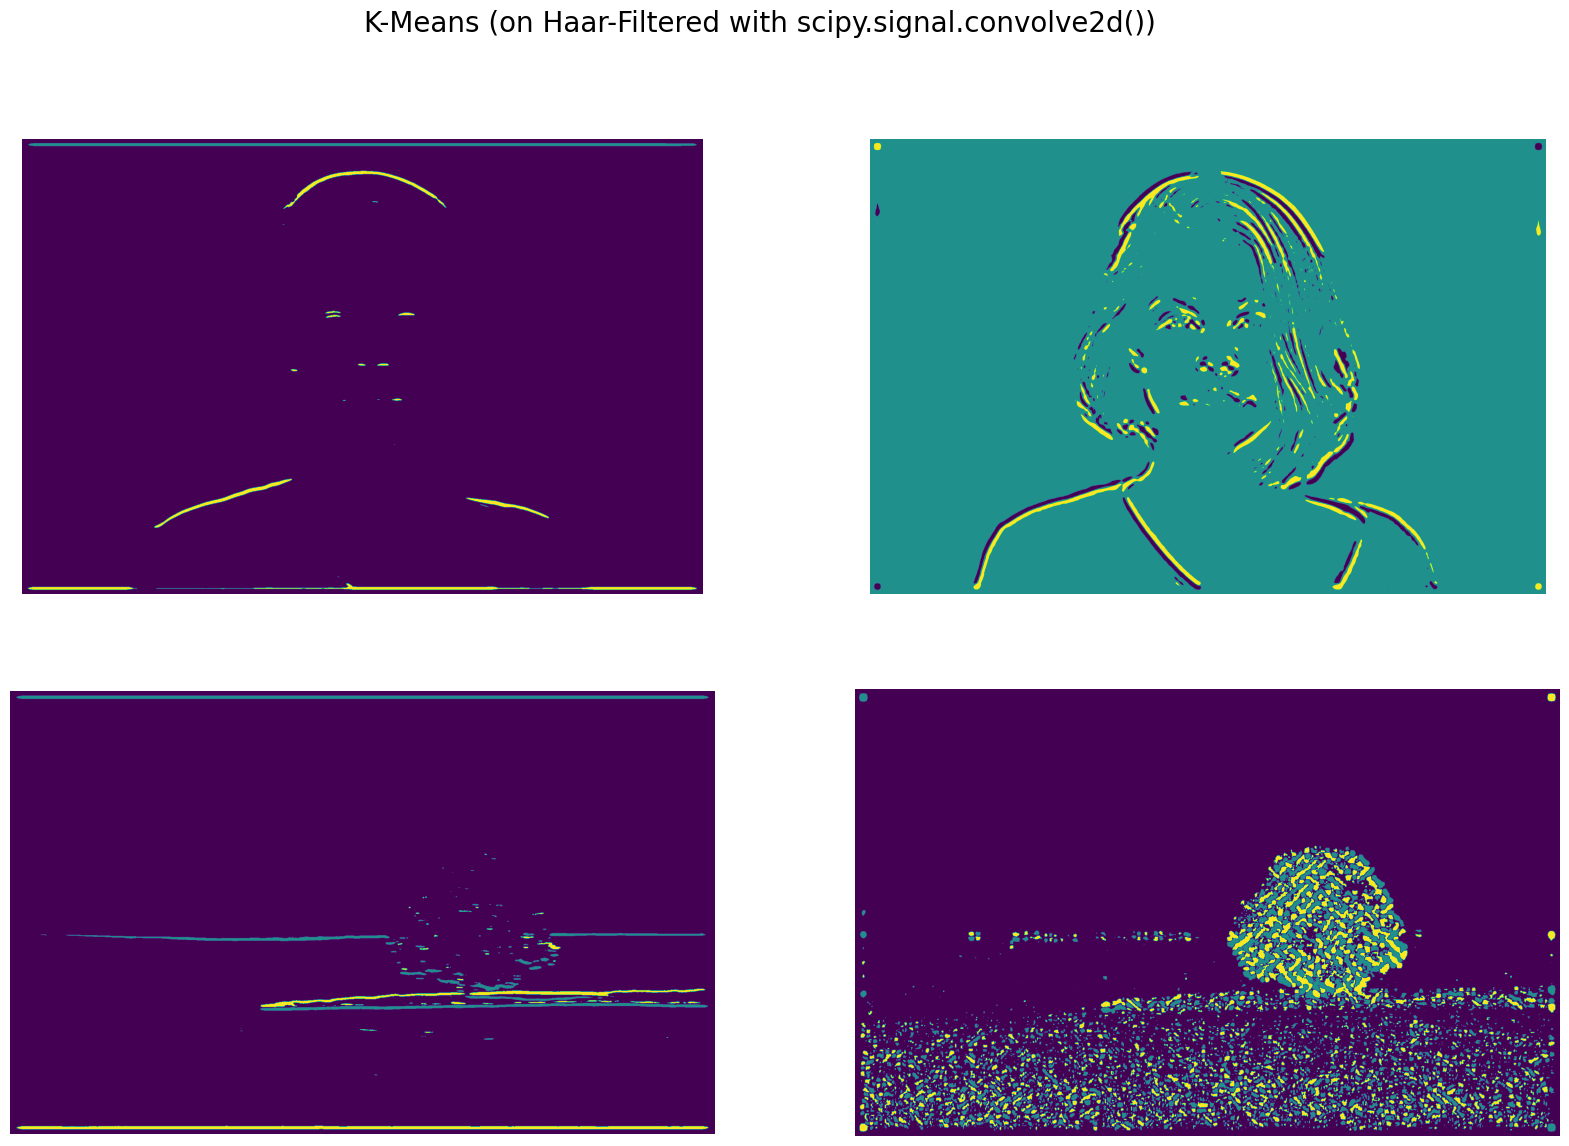

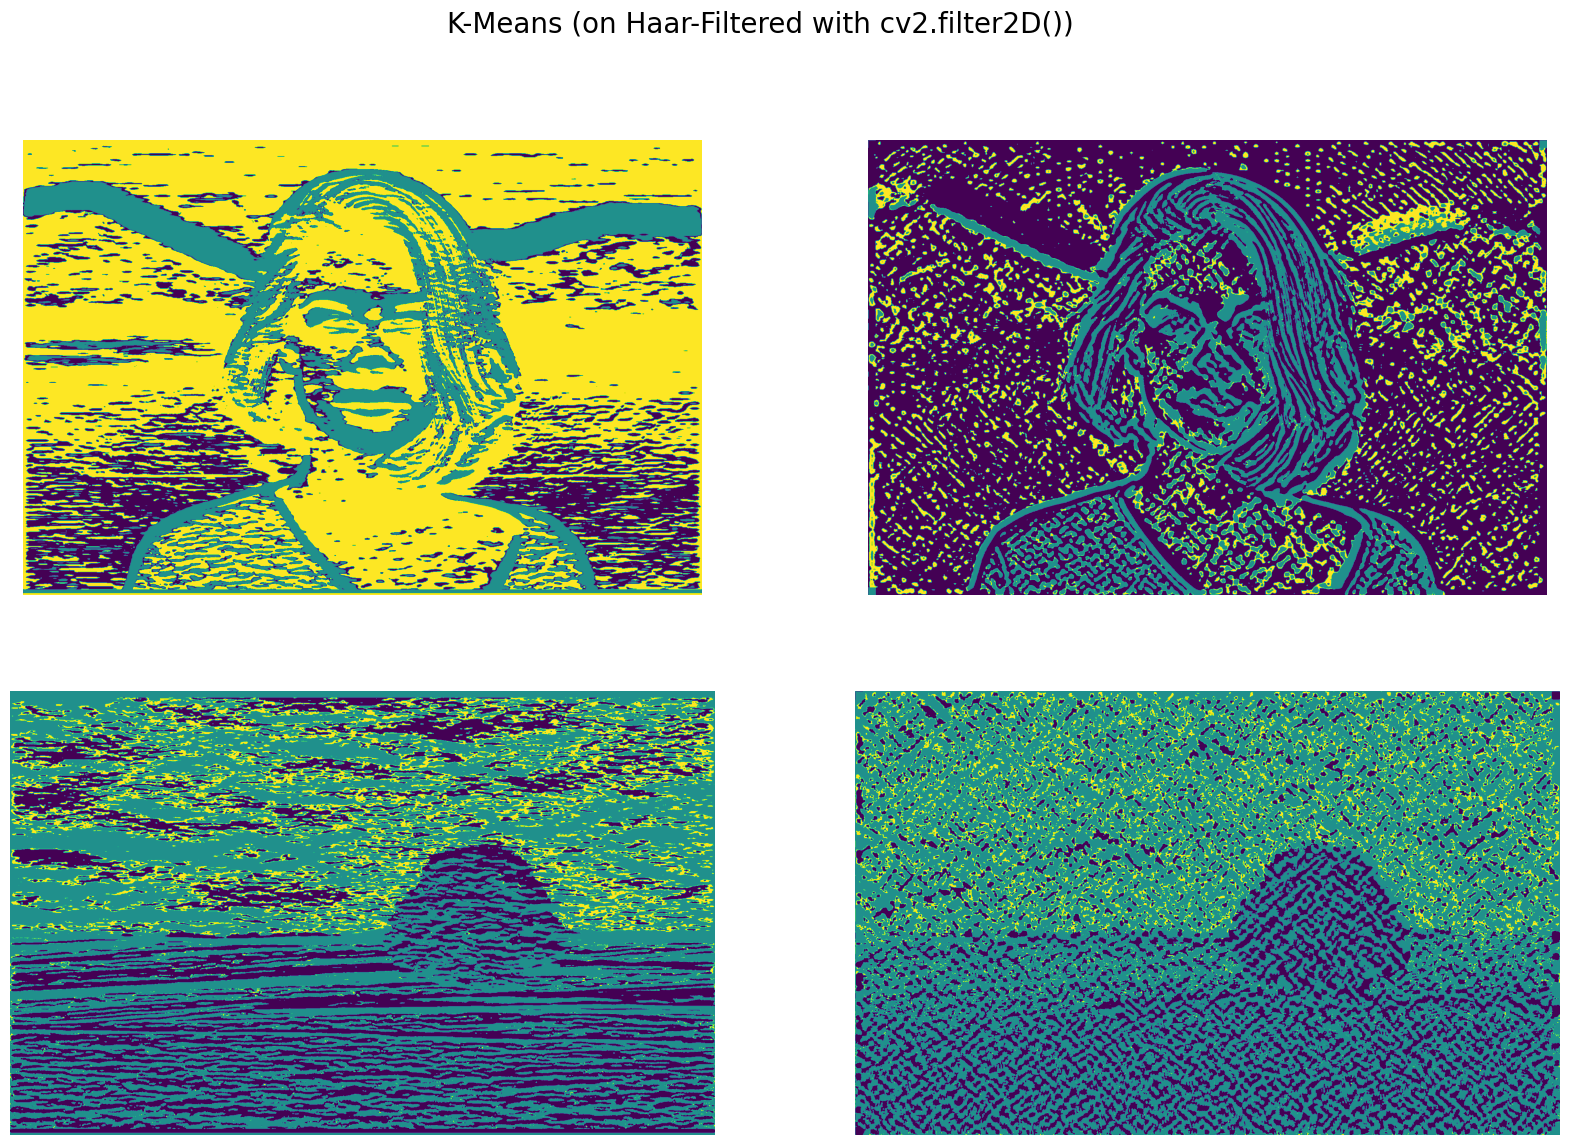

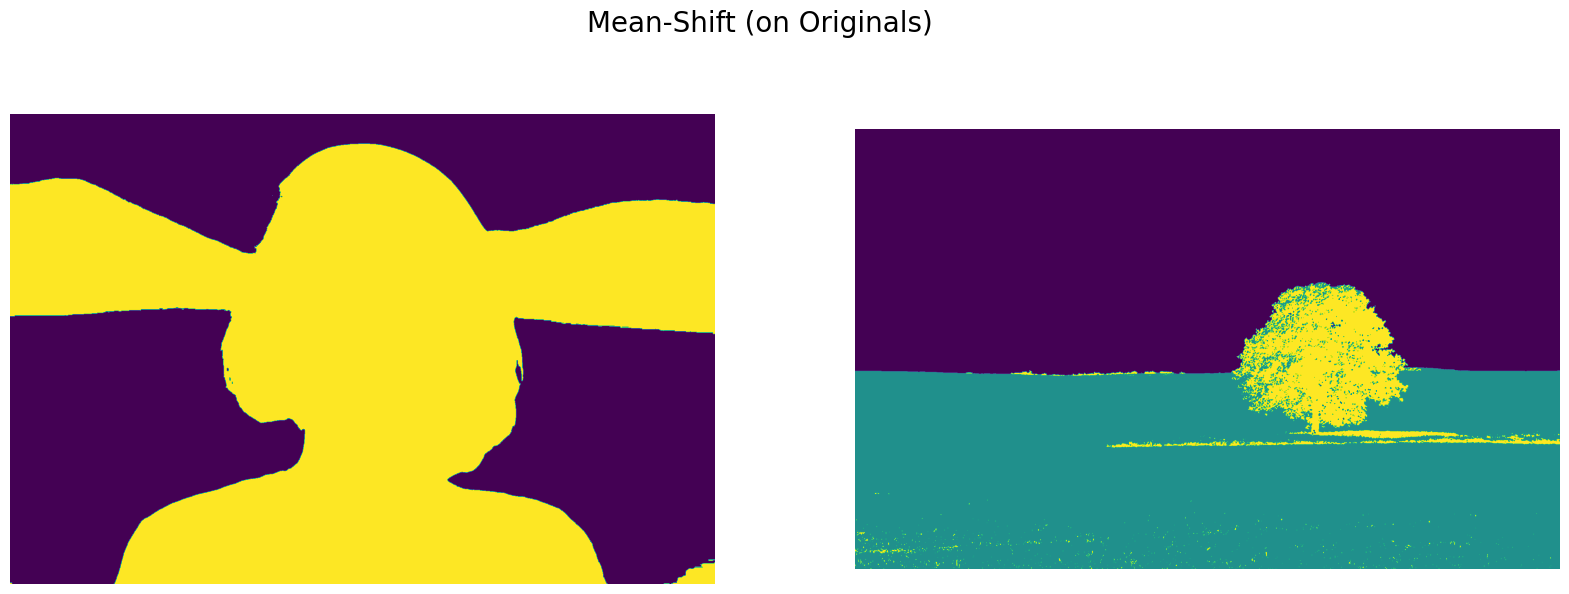

In [25]:
# balance between performance and speed when deciding n_init & n_samples
plt.figure(figsize = (20, 13))
plt.suptitle('K-Means (on Haar-Filtered with scipy.signal.convolve2d())', fontsize = 20)
for i, output in enumerate(out1):
    km = KMeans(n_clusters = 3, n_init = 10).fit(output.reshape((-1, 1)))
    plt.subplot(2, 2, i + 1)
    plt.imshow(km.labels_.reshape(output.shape))
    plt.axis('off')
plt.show()

plt.figure(figsize = (20, 13))
plt.suptitle('K-Means (on Haar-Filtered with cv2.filter2D())', fontsize = 20)
for i, output in enumerate(out2):
    km = KMeans(n_clusters = 3, n_init = 10).fit(output.reshape((-1, 1)))
    plt.subplot(2, 2, i + 1)
    plt.imshow(km.labels_.reshape(output.shape))
    plt.axis('off')
plt.show()

plt.figure(figsize = (20, 7))
plt.suptitle('Mean-Shift (on Originals)', fontsize = 20)
for i, pic in enumerate(pics):  # REF[3], TUT9, LEC 15  
    image = rgb2lab(cv2.imread(pic))
    ims = image.reshape((-1, 3))
    ms = MeanShift(bandwidth = esb(ims, n_samples = 50), bin_seeding = True).fit(ims)
    plt.subplot(1, 2, i + 1)
    plt.imshow(ms.labels_.reshape(image.shape[:2]))
    plt.axis('off')
plt.show()

#### Q1.4 Discuss the benefits and limitations of these clustering methods for image segmentation.

**K-Means**
Pros: Fast, efficient and easy to implement, so works well with large datasets;
Cons: Segmentation quality poorer than MeanShift, especially the portrait one. Requires predefining cluster number. Sensitive to initial centroid placements and outliers since it assumes clusters to be spherical.

**MeanShift**
Pros: Automatically determines the number of clusters and more flexible in identifying clusters of arbitrary shapes. Robust to outliers;
Cons: Computationally intensive with large datasets. Performance depends heavily on the choice of bandwidth params.

In general, KMeans appears preferable for simple images and large-scale segmentation tasks where processing speed is crucial and the number of clusters is known or can be estimated. MeanShift prevails in complex image segmentation scenarios and when cluster shapes are irregular.

&nbsp;
## II - Neural Network Implementation for Image Segmentation

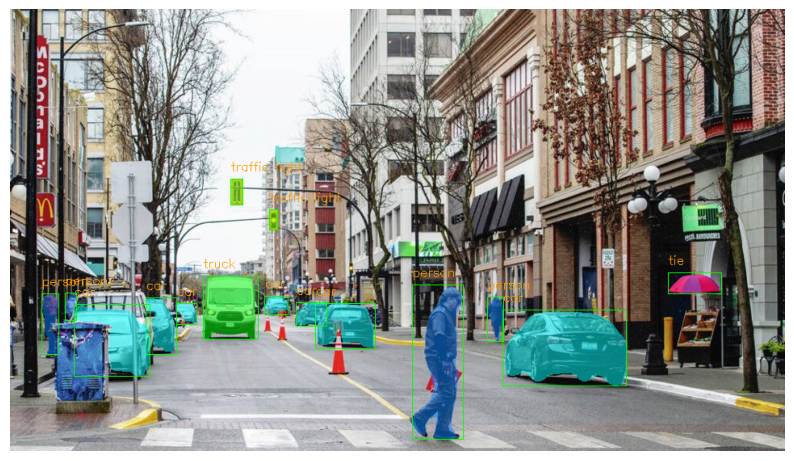

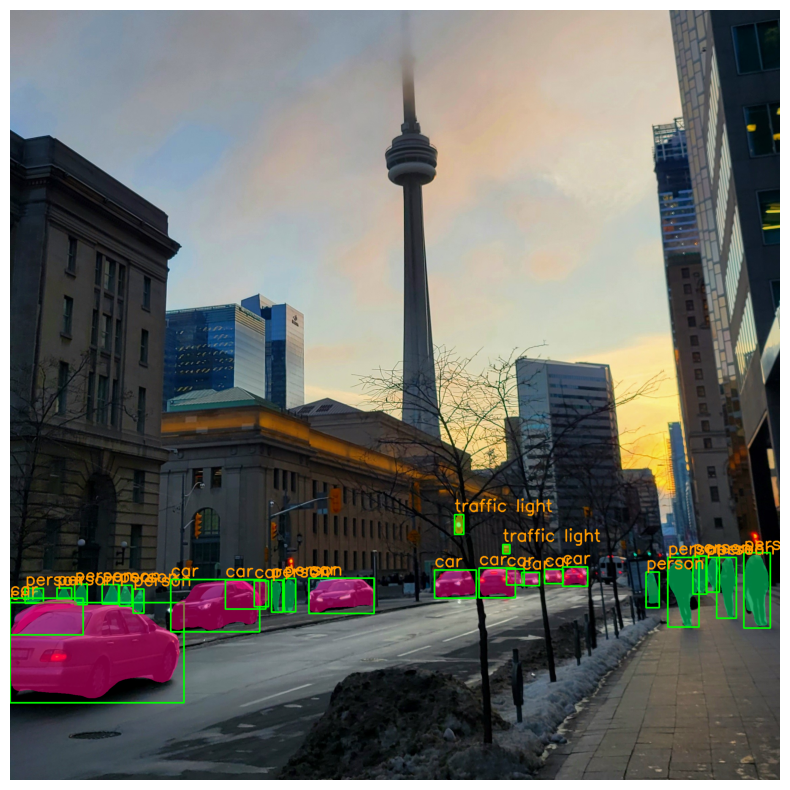

CPU times: total: 3.52 s
Wall time: 3.96 s


In [32]:
%%time
model = m(weights = M.DEFAULT).eval()
with open(PATH + 'coco.names', 'r') as f:
    COCO = f.read().splitlines()

def rcnn(path, confidence = 0.5):   # recognition certainty threshold. REF[4][7]
    img = cv2.imread(path)
    scale = ((img.shape[0] / 540) + (img.shape[1] / 960)) / 2  # reference resolution
    size, ply = 0.5 * scale, int(scale)   # scaled font size & box thickness for uniform outputs
    with no_grad():
        pred = model(t.Compose([t.ToTensor()])(img).unsqueeze(0))[0]
    keep = nms(pred['boxes'], pred['scores'], 0.3)
    uniq_cat = set(pred['labels'][keep].numpy())   # REF[4]
    # generate a dict of visually distinct colors for each category detected. objs of the same cat in different images are not necessarily assigned the same color. REF[5]
    n = len(uniq_cat)
    hue = hsv2rgb(np.stack([np.linspace(0, 1, n, endpoint = False), np.ones(n), np.ones(n)], axis = 1))
    palette = {cat - 1: hue[c] for c, cat in enumerate(uniq_cat)}
    plt.figure(figsize = (10, 10))
    for obj in [e for e in keep if pred['scores'][e] > confidence]:
        mask = pred['masks'][obj, 0].numpy()
        mask = mask > 0.5           # segmentation certainty threshold
        idx = pred['labels'][obj].item() - 1
        x1, y1, x2, y2 = pred['boxes'][obj].numpy().astype(int)  # box corner coords
        for k in range(3):  # REF[4]
            overlay = 0.5 * img[y1:y2, x1:x2, k] + 127.5 * palette.get(idx, [1, 1, 1])[k]   # overflow if combined
            img[y1:y2, x1:x2, k] = np.where(mask[y1:y2, x1:x2], overlay, img[y1:y2, x1:x2, k])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), thickness = ply)
        cv2.putText(img, COCO[idx], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, size, (0, 155, 255), thickness = ply)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

rcnn(PATH + 'street.png', 0.7) # optimal certainty depending on res
rcnn(PATH + 'toronto.jpg', 0.4)

'''
# REF[8]
def evaluate(preds, truths, th = 0.5):
    # true positive, false positive, false negative
    tp, fp, fn = 0, 0, 0
    for pred, truth in zip(preds, truths):
        if iou(pred['box'], truth['box']) > th:
            if pred['class'] == truth['class']:
                tp += 1
            else:
                fp += 1
        else:
            fp += 1
            fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

def iou(predBox, truthBox):
    x1 = max(predBox[0], truthBox[0])
    y1 = max(predBox[1], truthBox[1])
    x2 = min(predBox[2], truthBox[2])
    y2 = min(predBox[3], truthBox[3])
    intersection = max(0, y2 - y1 + 1) * max(0, x2 - x1 + 1)
    truthArea = (truthBox[2] - truthBox[0] + 1) * (truthBox[3] - truthBox[1] + 1)
    predArea = (predBox[2] - predBox[0] + 1) * (predBox[3] - predBox[1] + 1)
    union = predArea + truthArea - intersection
    return intersection / union
'''

#### Q2.4 Evaluate the performance of this model and explain the steps that this network took to achieve the final result.

#### Performance Evaluation
**Efficiency**: Runtimes above (varing with hardware). To test the average speed, consider importing a large amount of images then resizing; max instantaneous memory usage around 1.6GB (directly related to input size);
**Accuracy**: IOU approx 91% (reference purpose only, manually input ground truths, may be increased by lowering the confidence). For coco categories, the model works well in predicting most objects, and the segmentation works brilliantly as well. Hoping for a consistently reasonable predicted image, segmentation threshold were set to a convention value of 50% after test-running my algorithm. Nonetheless, there exist some mismatches: for instance in street.png, the umbrella on the right was classified to tie;
**Robustness**: Upon optimization, the model is robust to image resolution, size and orientation;
**Cross-nominal comparison**: After reviewing some other examples on GitHub, I can assert this implementation is doing quite well in terms of prediction accuracy (of course, credit to the model), but speed and edge fineness of segmentation can be improved. 0.9s/image(960×560) with i5-12600K is yet unsuitable for real-time applications.
Further and more quantitative evaluation metrics seem beyond my knowledge as an EE student.
&nbsp;
#### Steps Walk-Through
**1. Setup**: A Mask R-CNN model with a ResNet-50 backbone was loaded in evaluation mode, pre-trained on the COCO dataset, then from where categories were loaded to label-detected objects;
**2. Random Color Generator & Fontsize Scaler**
**3. Processing**: Load the image and convert to RGB format => passed through the model which provides predictions (adjustable confidence threshold) including bounding boxes / masks / labels => draw these features for each filtered prediction;
**4. Visualization**: Processed images were outputted.

&nbsp;
## References
1. **Face classification using Haar-like feature descriptor — skimage 0.22.0 documentation.** (n.d.-b).
    - [scikit-image](https://scikit-image.org/docs/stable/auto_examples/applications/plot_haar_extraction_selection_classification.html)
    - accessed Nov. 10, 2023
2. Viola, P., & Jones, M. (2001, December). Rapid object detection using a boosted cascade of simple features. In Proceedings of the 2001 IEEE computer society conference on computer vision and pattern recognition. CVPR 2001 (Vol. 1, pp. I-I). Ieee.
3. **TorchVision Object Detection Fine-tuning Tutorial — PyTorch Tutorials 2.1.0+cu121 documentation.** (n.d.). 
    - [pytorch.org](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
    - accessed Nov. 11, 2023
4. **sklearn.cluster.mean_shift.** (n.d.).
    - [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.mean_shift.html?highlight=estimate_bandwidth)
    - accessed Nov. 17, 2023
5. **How do I generate n visually distinct RGB colours in Python?** (n.d.).
    - [quora.com](https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python)
    - accessed Nov. 12, 2023
6. **Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow.** (n.d.-b).
    - [github.com](https://github.com/matterport/Mask_RCNN)
    - accessed Nov. 11, 2023
7. He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
8. **Python code to compute the intersection of two boundingboxes.** (n.d.).
    - [Gist](https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc)
    - accessed Nov. 22, 2023